<br><br>
<font size='6'><b>Class Activation Map (CAM)</b></font><br><br>

<br>
<div class=pull-right>
By Prof. Seungchul Lee<br>
http://iai.postech.ac.kr/<br>
Industrial AI Lab at POSTECH
</div>

Table of Contents
<div id="toc"></div>

- Attention

- Visualizing and Understanding Convolutional Networks


- Source
    - Source paper from http://cnnlocalization.csail.mit.edu/
    - Source code from https://github.com/metalbubble/CAM

# 1. CNN with a Fully Connected Layer


The conventional CNN can be conceptually divided into two parts. One part is feature extraction and the other is classification. In the feature extraction process, convolution is used to extract the features of the input data so that the classification can be performed well. The classification process classifies which group each input data belongs to by using the extracted features from the input data. 

When we visually identify images, we do not look at the whole image; instead, we intuitively focus on the most important parts of the image. CNN learning is similar to the way humans focus. When its weights are optimized, the more important parts are given higher weights. But generally, we are not able to recognize this because the generic CNN goes through a fully connected layer and makes the features extracted by the convolution layer more abstract.

<br>
<img src="./image_files/CNN.png" width = 700>
<br>

## 1.1. Issues on CNN (or Deep Learning)

- Deep learning performs well comparing with any other existing algorithms
- But works as a black box
    - A classification result is simply returned without knowing how the classification results are derived → little interpretability

- When we visually identify images, we do not look at the whole image 
- Instead, we intuitively focus on the most important parts of the image 
- When CNN weights are optimized, the more important parts are given higher weights

- Class activation map (CAM) 
    - We can determine which parts of the image the model is focusing on, based on the learned weights
    - Highlighting the importance of the image region to the prediction

<br>
<img src="./image_files/cam_paper.png" width = 700>
<br>

# 2. CAM: CNN with a Global Average Pooling

- shed light on how it explicitly enables the convolutional neural network to have remarkable localization ability
- the heatmap is the class activation map, highlighting the importance of the image region to the prediction

The deep learning model is a black box model. When input data is received, a classification result of 1 or 0 is simply returned for the binary classification problem, without knowing how the classification results are derived. Meanwhile, The class activation map (CAM) is capable of interpreting the results of the classification. We can determine which parts of the image the model is focusing on. Through an analysis of which part of the image the model is focusing on, we are able to interpret which part of the image is considered important.

The class activation map (CAM) is a modified convolution layer. It directly highlights the important parts of the spatial grid of an image. As a result, we can see the emphasized parts of the model. The below figure describes the procedure for class activation mapping.

<br>
<img src="./image_files/CAM.png" width = 700>
<br>

The feature maps of the last convolution layer can be interpreted as a collection of visual spatial locations focused on by the model. The CAM can be obtained by taking a linear sum of the features. They all have different weights and thus can obtain spatial locations according to various input images through a linear combination. For a given image, $f_k(x,y)$ represents the feature map of unit $k$ in the last convolution layer at spatial location $(x,y)$. For a given class $c$, the class score, $S_c$, is expressed as the following equation. 

<br>
$$S_c = \sum_k \omega_k^c \sum_{x,y} f_k(x,y)=  \sum_{x,y} \sum_k \omega_k^c \; f_k(x,y)$$
<br>

where $\omega_k^c$ the weight corresponding to class $c$  for unit $k$. The class activation map for class $c$ is denoted as $M_c$.

<br>
$$M_c(x,y) = \sum_k \omega_k^c \; f_k(x,y)$$
<br>

$M_c$ directly indicates the importance of the feature map at a spatial grid $(x,y)$ of the class $c$. Finally the output of the softmax for class $c$ is,

<br>
$$P_c = \frac{\exp\left(S_c\right)}{\sum_c \exp\left(S_c\right)}$$
<br>

In case of the CNN, the size of the feature map is reduced by the pooling layer. By simple up-sampling, it is possible to identify attention image regions for each label.

In [1]:
# fit error 발생시 실행
from tensorflow.compat.v1 import ConfigProto, Session
from tensorflow.compat.v1.keras.backend import set_session

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.3
session = Session(config=config)
set_session(session)

# 3. CAM with MNIST 

In [1]:
!nvidia-smi

Wed Apr 28 15:14:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:03:00.0  On |                  N/A |
| 24%   43C    P8    12W / 250W |    422MiB / 11175MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:04:00.0 Off |                  N/A |
| 29%   35C    P8     9W / 250W |    147MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [2]:
import os 
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [4]:
mnist = tf.keras.datasets.mnist

(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x, test_x = train_x/255.0, test_x/255.0
train_x = train_x.reshape((train_x.shape[0], 28, 28, 1))
test_x = test_x.reshape((test_x.shape[0], 28, 28, 1))

In [11]:
'''
0 ~ 9까지의 숫자 중 7,9 class에 해당하는 train, test dataset 구성
'''
# digits of 7 and 9 will be used
train_idx = np.hstack((np.where(train_y == 7), np.where(train_y == 9)))[0]
test_idx = np.hstack((np.where(test_y == 7), np.where(test_y == 9)))[0]

train_imgs = train_x[train_idx]
train_labels = train_y[train_idx]
test_imgs = test_x[test_idx]
test_labels = test_y[test_idx]

n_train = train_imgs.shape[0]
n_test = test_imgs.shape[0]

print ("The number of train images: {}, shape: {}".format(n_train, train_imgs.shape))
print ("The number of test images: {}, shape: {}".format(n_test, test_imgs.shape))

The number of train images: 12214, shape: (12214, 28, 28)
The number of test images: 2037, shape: (2037, 28, 28)


In [12]:
# binary classification
# label 7 to 0 
# label 9 to 1

train_y = (train_labels == 9).astype(int)
test_y = (test_labels == 9).astype(int)

In [13]:
'''
kears sequential model
Conv2D(channel: 32) - MaxPool2D - Conv2D(Channel: 64) - MaxPool2D - GlobalAveragePooling2D - Dense

kernel: (3,3)
activation = (relu)
'''
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,
                           (3,3),
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (28, 28, 1)),
    tf.keras.layers.MaxPool2D((2,2)),
    
    tf.keras.layers.Conv2D(64,
                           (3,3),
                           activation = 'relu',
                           padding = 'SAME'
                          ),
    tf.keras.layers.MaxPool2D((2,2)),
    
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation = 'softmax', use_bias = False) # 분류기 = softmax, 
                                                                        # 학습할때 weight와 bias를 쓰는데 bias를 안쓰게 막음
                                                                        # 학습할 떄마다 weight가 곱하고 bias가 더해지는데 bias의 영향을 적게보겠다.
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 128       
Total params: 18,944
Trainable params: 18,944
Non-trainable params: 0
____________________________________________________

<br>
<img src="./image_files/CAM.png" width = 700>
<br>

In [8]:
'''
compile

optimizer: adam
loss: sparse_categorical_crossentroy
metrics: accuracy
'''
model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy']
             )

In [9]:
train_labels

array([7, 7, 7, ..., 9, 9, 9], dtype=uint8)

In [10]:
train_imgs.shape

(12214, 28, 28, 1)

In [11]:
train_y.shape

(12214,)

In [12]:
'''
model.fit
'''
model.fit(train_imgs, train_y, batch_size = 32, epochs = 10)

Epoch 1/10
382/382 [==============================] - 4s 11ms/step - loss: 0.4236 - accuracy: 0.8198
Epoch 2/10
382/382 [==============================] - 1s 4ms/step - loss: 0.2051 - accuracy: 0.9336
Epoch 3/10
382/382 [==============================] - 1s 4ms/step - loss: 0.1532 - accuracy: 0.9492
Epoch 4/10
382/382 [==============================] - 1s 4ms/step - loss: 0.1282 - accuracy: 0.9583
Epoch 5/10
382/382 [==============================] - 1s 4ms/step - loss: 0.1116 - accuracy: 0.9640
Epoch 6/10
382/382 [==============================] - 1s 4ms/step - loss: 0.0974 - accuracy: 0.9675
Epoch 7/10
382/382 [==============================] - 1s 4ms/step - loss: 0.0947 - accuracy: 0.9686
Epoch 8/10
382/382 [==============================] - 1s 4ms/step - loss: 0.0852 - accuracy: 0.9708
Epoch 9/10
382/382 [==============================] - 1s 4ms/step - loss: 0.0801 - accuracy: 0.9740
Epoch 10/10
382/382 [==============================] - 1s 4ms/step - loss: 0.0774 - accuracy: 0.973

In [13]:
'''
model.evalute
'''
test_loss, test_acc =model.evaluate(test_imgs, test_y)

print('loss = {}, Accuracy = {} %'.format(round(test_loss,8), round(test_acc*100)))

64/64 [==============================] - 1s 23ms/step - loss: 0.0774 - accuracy: 0.9750
loss = 0.07736602, Accuracy = 97 %


In [14]:
print(model.get_layer(index = 0))
print(model.get_layer(index = 1))
print(model.get_layer(index = 2))
print(model.get_layer(index = 3))
print(model.get_layer(index = 4))
print(model.get_layer(index = 5))

In [15]:
model.get_layer(index = 3).output

<tf.Tensor 'max_pooling2d_1/Identity:0' shape=(None, 7, 7, 64) dtype=float32>

In [16]:
len(model.get_weights())

5

In [17]:
print(model.get_weights()[0].shape)
print(model.get_weights()[1].shape)
print(model.get_weights()[2].shape)
print(model.get_weights()[3].shape)
print(model.get_weights()[4].shape)

(3, 3, 1, 32)
(32,)
(3, 3, 32, 64)
(64,)
(64, 2)


In [18]:
# get maxpooling layer and fully connected layer

'''
get max pooling layer(hint: model.get_layer(index = ?))
get fully connected layer(hint: model.get_weights()[?], np.asarray())

model.get_layer(index = ?)
model.get_weights()[?]
'''

conv_layer = model.get_layer(index = 3)
fc_layer = np.asarray(model.get_weights())[4]

/home/piai/anaconda3/envs/abc/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [19]:
# Class activation map

'''
activation map = max_pooling_layer * weight
CAM model architecture (hint: tf.keras.Model(inputs = , outputs = ))
'''

activation_map = tf.matmul(conv_layer.output, fc_layer)
CAM_model = tf.keras.Model(inputs = model.inputs, outputs = activation_map)

In [20]:
test_img = test_imgs[np.random.choice(test_imgs.shape[0], 1)]
test_img.shape

(1, 28, 28, 1)

In [21]:
# Class activation map

'''
test_imgs 1개 랜덤 sampling
test_img를 이용하여 CAM model로 predict
predicted class기반의 class activation map (attention) 제작
'''

test_img = test_imgs[np.random.choice(test_imgs.shape[0], 1)]

pred = np.argmax(model.predict(test_img), axis=1)
pred

array([0])

In [22]:
CAM = CAM_model.predict(test_img)
attention = CAM[:,:,:,pred]

In [23]:
CAM.shape

(1, 7, 7, 2)

In [24]:
attention.shape

(1, 7, 7, 1)

In [25]:
attention = np.reshape(attention,(7,7))

In [26]:
large_test_x = cv2.resize(test_img.reshape(28,28), (28*5, 28*5))
large_attention = cv2.resize(attention, (28*5, 28*5), interpolation = cv2.INTER_CUBIC)

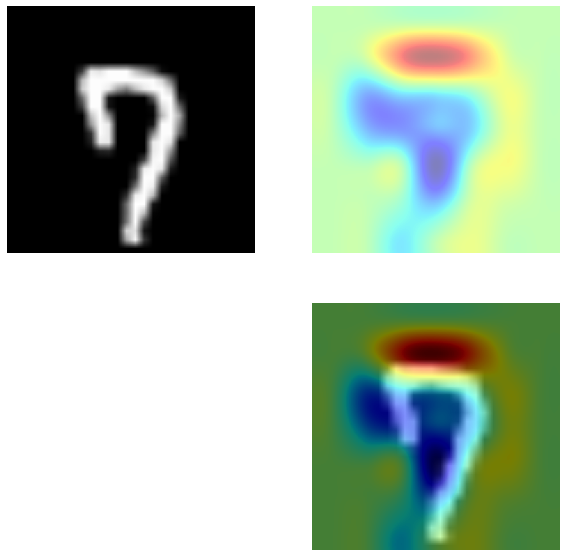

In [27]:
plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
plt.imshow(large_test_x, 'gray')
plt.axis('off')
plt.subplot(2,2,2)
plt.imshow(large_attention, 'jet', alpha = 0.5)
plt.axis('off')
plt.subplot(2,2,4)
plt.imshow(large_test_x, 'gray')
plt.imshow(large_attention, 'jet', alpha = 0.5)
plt.axis('off')
plt.show()

In [14]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>